In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import sklearn 



In [60]:
import torch as pt
from torch import nn 

In [61]:
from torch.utils.data import TensorDataset, DataLoader

In [62]:
def preprocess_inputs(df):

    df = df.copy()
   

    # Drop Route
    df = df.drop(['Route'], axis=1)
    
    # Extract Days and Months from Date of journey
    df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'])
    df['Day of Journey'] = df['Date_of_Journey'].dt.day
    df['Month of Journey'] = df['Date_of_Journey'].dt.month
    df = df.drop('Date_of_Journey', axis=1)
   
    
    # Convert and encode departure and arrival time to 4 different times of the day (morning, noon, afternoon, evening)
    df['Dep_Time'] = pd.to_datetime(df['Dep_Time']).dt.hour/6
    df['Arrival_Time'] = pd.to_datetime(df['Arrival_Time']).dt.hour/6
    
    # Duration converting to minutes
    df['H'] = df['Duration'].str.extract(r'(\d*(?=h))')
    df['M'] = df['Duration'].str.extract(r'(\d*(?=m))')
    df[['H', 'M']] = df[['H', 'M']].fillna(0)
    df[['H', 'M']] = df[['H', 'M']].astype(int)
    df['Duration'] = df['H'] * 60 + df['M']
    df = df.drop(['H', 'M'], axis=1)
    


    # Features from Additional info and total stops 
    
    df['Total_Stops']=df['Total_Stops'].map({'non-stop':0 ,'1 stop':1 ,'2 stops':2,'3 stops':3,'4 stops':4})
    df['Meal'] = df['Additional_Info'].map({'In-flight meal not included':1, 'No info':0})
    df['Baggage'] = df['Additional_Info'].map({'No check-in baggage included':1,'No info':0 })
    df = df.drop('Additional_Info', axis=1)
    
    
    # Source, Destination and Airline encoding (One-hot)
    df = pd.concat([df, pd.get_dummies(df['Source'], prefix='S')], axis=1)
    df = pd.concat([df, pd.get_dummies(df['Destination'], prefix='D')], axis=1)
    df = pd.concat([df, pd.get_dummies(df['Airline'])], axis=1)
    df = df.drop(['Source', 'Destination','Airline'], axis=1)
   
    df = df.fillna(0) #to avoid null values 
    
    
    #find mean and standard deviation of the price
    mean = df['Price'].mean()
    std = df['Price'].std()
    min = df['Price'].min()
    max = df['Price'].max()

    
   
    # Split X and y
    X = df.drop(['Price'], axis=1)
    y = np.log(df['Price'])
    X_scaled = (X -np.min(X))/(np.max(X)-np.min(X))
    y_scaled = (y -np.min(y))/(np.max(y)-np.min(y))

    
    # Train-test-validation split   
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=0)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)


    

    """
    #exploratory data analysis
    corr = df.corr() #to see the correlation between each feature and the price 
    plt.figure(figsize=(12,10))
    sns.heatmap(corr.corr(),cmap = 'coolwarm', annot=False)
    """
    
    return X_train, X_val, X_test, y_train, y_val, y_test, mean, std, min, max

In [63]:
data = pd.read_excel('Data_Train.xlsx')

/var/folders/fk/fnjsfmtx3kz8w_rw6p8q4zzm0000gn/T/ipykernel_16355/563107218.py:10: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'])
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(ax

       Dep_Time  Arrival_Time  Duration  Total_Stops  Day of Journey  \
1502   0.478261      0.173913  0.348511         0.50           0.125   
3560   0.782609      0.521739  0.383538         0.25           0.750   
8846   0.478261      0.565217  0.045534         0.00           0.000   
3880   0.869565      1.000000  0.577933         0.25           0.125   
5862   0.782609      0.782609  0.514886         0.25           0.000   
...         ...           ...       ...          ...             ...   
10584  0.782609      0.826087  0.518389         0.25           0.875   
5851   0.260870      0.521739  0.625219         0.50           1.000   
9034   0.695652      0.173913  0.259194         0.25           0.125   
8241   0.695652      0.913043  0.103327         0.25           1.000   
9483   0.391304      0.826087  0.208406         0.25           0.125   

       Month of Journey  Meal  Baggage  S_Banglore  S_Chennai  ...  GoAir  \
1502           0.454545   1.0      0.0         0.0        

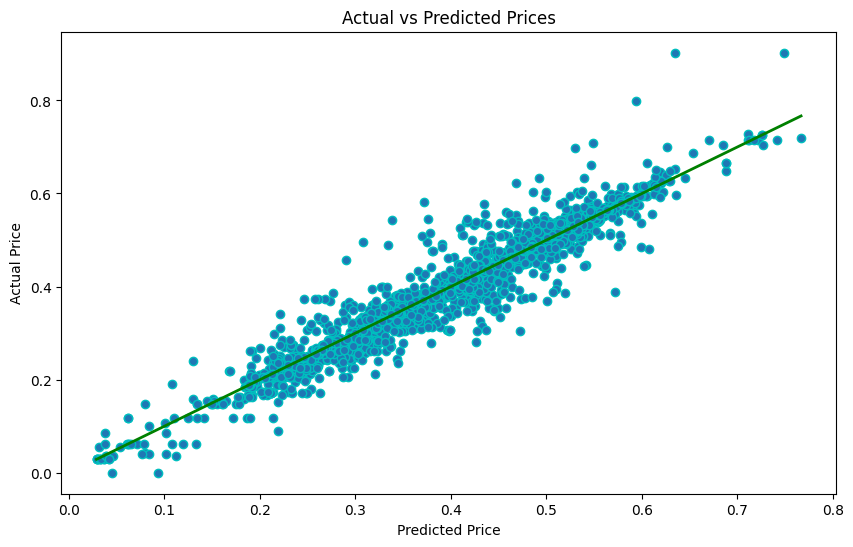

Linear : R2 Score = 0.7573
                   RMSE = 0.0665
                    MAE = 0.0498
                   MAPE = 50631289076074.54 %



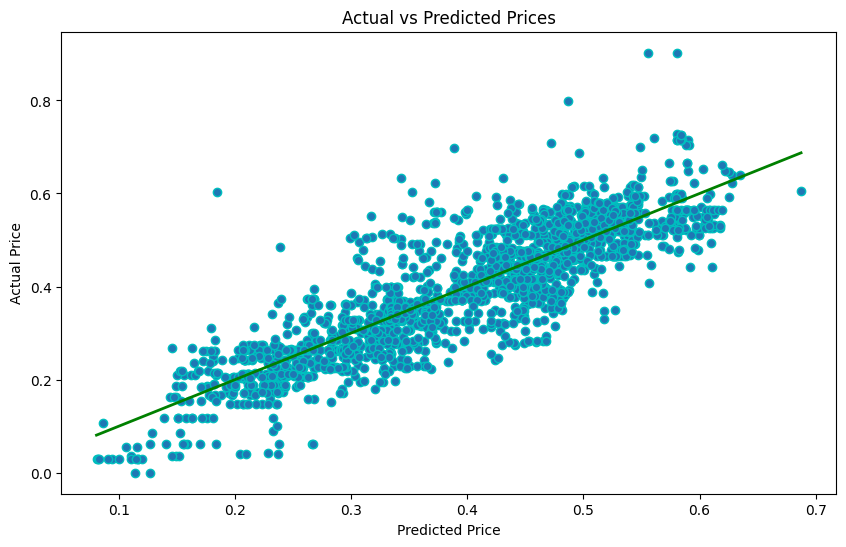

9918     0.424080
5687     0.194184
10404    0.327020
8933     0.462773
8375     0.539812
           ...   
6867     0.288461
9971     0.211798
10610    0.187700
10102    0.390827
6419     0.210196
Name: Price, Length: 1710, dtype: float64


In [64]:
X_train, X_test, X_val, y_train, y_test, y_val, mean, std, min, max  = preprocess_inputs(data)

print(X_train)
print(y_train)
print(X_test)
print(y_test)


print("-------- Training --------")
list1=[RandomForestRegressor(), LinearRegression()]
for i in list1:
    i.fit(X_train, y_train)

print("Random forest trained!")
print("Linear trained!")
print("---------- Done ----------")





for i in list1:
    y_pred = i.predict(X_val)
    if i == list1[0]:
        print("Random Forest : R2 Score = {:.4f}".format(r2_score(y_val, y_pred)))
        print("                   RMSE = {:.4f}".format(np.sqrt(mean_squared_error(y_val, y_pred))))
        print("                    MAE = {:.4f}".format(mean_absolute_error(y_val, y_pred)))
        print("                   MAPE = {:.2f} %\n".format(mean_absolute_percentage_error(y_val, y_pred) * 100))
    else:
        print("Linear : R2 Score = {:.4f}".format(r2_score(y_val, y_pred)))
        print("                   RMSE = {:.4f}".format(np.sqrt(mean_squared_error(y_val, y_pred))))
        print("                    MAE = {:.4f}".format(mean_absolute_error(y_val, y_pred)))
        print("                   MAPE = {:.2f} %\n".format(mean_absolute_percentage_error(y_val, y_pred)*100))        
       

    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, y_val, edgecolor='c')
    
    plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], c='g', lw=2)
    plt.title("Actual vs Predicted Prices")
    plt.xlabel("Predicted Price")
    plt.ylabel("Actual Price")
    plt.show()

print(y_test)


In [65]:
class Net(nn.Module):
    #define layers
    #number of input features is 31
    #number of output features is 1
    #number of hidden nodes layer 1 is 100
    #number of hidden nodes layer 2 is 100
    #activation function is Leaky ReLU
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = pt.nn.Linear(31,100)
        self.fc2 = pt.nn.Linear(100,100)
        self.fc3 = pt.nn.Linear(100, 1)
        self.relu = pt.nn.LeakyReLU()
        self.dropout = pt.nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        #x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        #x = self.dropout(x)
        x = self.fc3(x)
        return x






In [66]:
## Check to see if we have a GPU to use for training
device = 'cuda' if pt.cuda.is_available() else 'cpu'
print('A {} device was detected.'.format(device)) 

# Print the name of the cuda device, if detected
if device=='cuda':
  print (pt.cuda.get_device_name(device=device))


#convert data to tensors
X_train = pt.from_numpy(X_train.values).float()
y_train = pt.from_numpy(y_train.values).float()
X_test = pt.from_numpy(X_test.values).float()
y_test = pt.from_numpy(y_test.values).float()
X_val = pt.from_numpy(X_val.values).float()
y_val = pt.from_numpy(y_val.values).float()


#divide data into batches
train = TensorDataset(X_train, y_train)
train_loader = DataLoader(train, batch_size=10, shuffle=True)

test = TensorDataset(X_test, y_test)
test_loader = DataLoader(test, batch_size=10, shuffle=True)

valid = TensorDataset(X_val, y_val)
valid_loader = DataLoader(valid, batch_size=10, shuffle=True)


A cpu device was detected.


In [67]:
#initialize the NN
model = Net()

#loss function
criterion = pt.nn.MSELoss()

#optimizer
optimizer = pt.optim.SGD(model.parameters(), lr=0.00005)


#number of epochs to train the model
n_epochs = 100

#initialize tracker for minimum validation loss
valid_loss_min = np.Inf #set initial "min" to infinity

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely le

Epoch: 1 	Training Loss: 0.161365 	Validation Loss: 0.146270
Epoch: 2 	Training Loss: 0.126749 	Validation Loss: 0.115892
Epoch: 3 	Training Loss: 0.100568 	Validation Loss: 0.092739
Epoch: 4 	Training Loss: 0.080667 	Validation Loss: 0.075241
Epoch: 5 	Training Loss: 0.065649 	Validation Loss: 0.061743
Epoch: 6 	Training Loss: 0.054225 	Validation Loss: 0.051601
Epoch: 7 	Training Loss: 0.045483 	Validation Loss: 0.043810
Epoch: 8 	Training Loss: 0.038922 	Validation Loss: 0.037921
Epoch: 9 	Training Loss: 0.034014 	Validation Loss: 0.033473
Epoch: 10 	Training Loss: 0.030266 	Validation Loss: 0.030097
Epoch: 11 	Training Loss: 0.027479 	Validation Loss: 0.027553
Epoch: 12 	Training Loss: 0.025405 	Validation Loss: 0.025662
Epoch: 13 	Training Loss: 0.023817 	Validation Loss: 0.024257
Epoch: 14 	Training Loss: 0.022642 	Validation Loss: 0.023119
Epoch: 15 	Training Loss: 0.021815 	Validation Loss: 0.022251
Epoch: 16 	Training Loss: 0.021144 	Validation Loss: 0.021604
Epoch: 17 	Traini

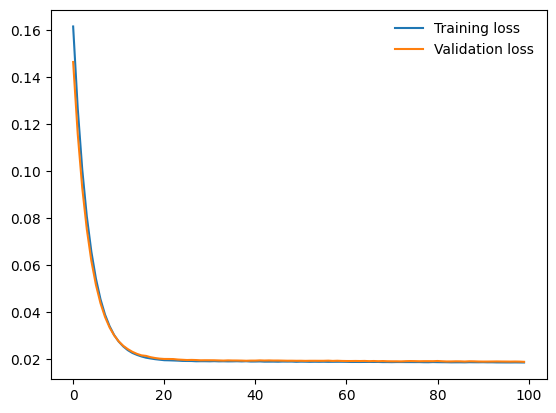

In [68]:
vloss = []
tloss = []
for epoch in range(1, n_epochs+1):
        
        #initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        
        
        ###################
        # train the model #
        ###################
        model.train() #prep model for training
        for data, target in train_loader:
            #clear the gradients of all optimized variables
            optimizer.zero_grad()
            #forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            #calculate the batch loss
            loss = criterion(output, target)
            #backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            #perform a single optimization step (parameter update)
            optimizer.step()
            #update running training loss
            train_loss += loss.item()*data.size(0)
        

        model.eval() #prep model for evaluation
        for data, target in valid_loader:
            #forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            #calculate the batch loss
            loss = criterion(output, target)
            #update running validation loss 
            valid_loss += loss.item()*data.size(0)
       

        #calculate average losses
        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(valid_loader.dataset)
        
        tloss.append(train_loss)
        vloss.append(valid_loss)
        #print training/validation statistics
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch,
            train_loss,
            valid_loss
            ))
        #plot training and validation loss
#plot the training and validation loss vs number of epochs

plt.plot(tloss, label='Training loss')
plt.plot(vloss, label='Validation loss')
plt.legend(frameon=False)
plt.show()


Test Loss: 0.019907



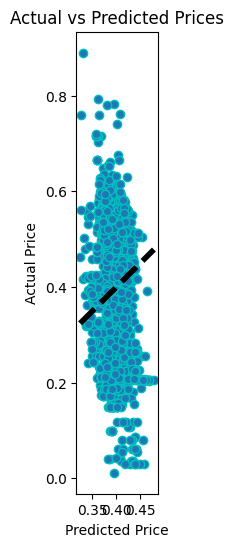

In [69]:
#test the model
model.eval() #prep model for evaluation
test_loss =0.0
preds = []
actuals = []

for data, target in test_loader:
    #forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    #calculate the batch loss
    loss = criterion(output, target)
    #update running validation loss 
    test_loss += loss.item()*data.size(0)


    output = output.detach().numpy()

    target = target.detach().numpy()

    preds.append(output)
    actuals.append(target)


print('Test Loss: {:.6f}\n'.format(test_loss/len(test_loader.dataset)))


# Plot actuals vs predictions
plt.figure(figsize=(10, 6))
plt.scatter(preds, actuals, edgecolor='c')
plt.plot([np.min(preds), np.max(preds)], [np.min(preds), np.max(preds)], 'k--', lw=4)
plt.title("Actual vs Predicted Prices")
plt.xlabel("Predicted Price")
plt.ylabel("Actual Price")
        

# Make the display equal in both dimensions
plt.gca().set_aspect('equal', adjustable='box')
plt.show()




